<a href="https://colab.research.google.com/github/miraclehimself/Advanced_ML/blob/main/Partial_Dependency_Plot_(PDP)_and_Individual_Conditional_Expectation_(ICE)_Lecture_week6a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AML 22-23 S2W6 PDP/ICE Lecture

Key Points:

* Partial Dependency Plot (PDP) and Individual Conditional Expectation (ICE).

* Alongside SHAP, some of my favourite techniques/tools for making sense of complex and/or opaque models.

* **ICE**: Assume that we would like to explore a counterfactual scenario. Pick an observation (e.g., patient 0 in Diabetes dataset). Model's prediction is `yes` (onset of diabetes within a particular period) with probability 0.7. What happens if I change BMI from 25 to 30? How would the target be affected? And beyond - let us see what happens for the whole range of BMI (say, 15 to 40) for that observation, while keeping everything else fixed. The curve we get of predict target against BMI is an **ICE**.

* **PDP**: Pick the average ICE from all ICE produced for the feature (or pair of features) and observation.

* Caveats:
    - Computationally expensive - need shortcuts/optimisation.
    - We are looking at a single feature or pair of features, normally. It averages effects across all remaining features.
    - Traditional way of generating synthetic data may create non-sensical data points (e.g., a small house with 40 bedrooms).


## Packages

In [ ]:
!pip install --upgrade scikit-learn category_encoders -q --user
# need to restart kernel, if latest versions not already installed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set(
    style='ticks',
    context='talk',
    font_scale=0.8,
    rc={'figure.figsize': (8,6)}
)

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid

In [ ]:
from sklearn.metrics import mean_squared_error
from functools import partial
rmse = partial(mean_squared_error, squared=False)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# from category_encoders import TargetEncoder

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [ ]:
!pip install -q shap
import shap
shap.initjs()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 15.0 MB/s eta 0:00:00


## Regression Example with Bike Rides

### Dataset

In [ ]:
rides_full = pd.read_csv(
    'https://raw.githubusercontent.com/christophM/interpretable-ml-book/master/data/bike.csv'
)

In [ ]:
rides_full.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0


In [ ]:
rides_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   season           731 non-null    object 
 1   yr               731 non-null    int64  
 2   mnth             731 non-null    object 
 3   holiday          731 non-null    object 
 4   weekday          731 non-null    object 
 5   workingday       731 non-null    object 
 6   weathersit       731 non-null    object 
 7   temp             731 non-null    float64
 8   hum              731 non-null    float64
 9   windspeed        731 non-null    float64
 10  cnt              731 non-null    int64  
 11  days_since_2011  731 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 68.7+ KB


In [ ]:
rides = rides_full[
    [ 'season', 'workingday', 'temp', 'hum', 'windspeed', 'days_since_2011', 'cnt' ]
].rename(columns=dict(days_since_2011='days_elapsed', cnt='rides_count'))

In [ ]:
rides.head()

,season,workingday,temp,hum,windspeed,days_elapsed,rides_count
0,WINTER,NO WORKING DAY,8.175849,80.5833,10.749882,0,985
1,WINTER,NO WORKING DAY,9.083466,69.6087,16.652113,1,801
2,WINTER,WORKING DAY,1.229108,43.7273,16.636703,2,1349
3,WINTER,WORKING DAY,1.400000,59.0435,10.739832,3,1562
4,WINTER,WORKING DAY,2.666979,43.6957,12.522300,4,1600


In [ ]:
X, y = rides.drop(columns='rides_count'), rides['rides_count']

NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=0)

### Pre-Processing and Model Fitting Pipelines

In [ ]:
numeric_features = X_train.select_dtypes(exclude='object').columns.tolist()
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
).set_output(transform='pandas')

In [ ]:
categorical_features = X_train.select_dtypes(include='object').columns.tolist()
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop='if_binary')),
    ]
).set_output(transform='pandas')

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [ ]:
regr_model = RandomForestRegressor(
    max_depth=8, min_samples_split=15, min_samples_leaf=8, n_estimators=400
)
regr_model = HistGradientBoostingRegressor(
    max_depth=8, max_iter=400
)


In [ ]:
regr_pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regr", regr_model)
    ]
).set_output(transform="pandas")

In [ ]:
regr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['temp', 'hum', 'windspeed',
                                                   'days_elapsed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['season', 'workingday'])],
                                   verbose_feature_names_out=False)),
                ('regr',
                 HistGradientBoostingRegressor(max_depth=8, max_iter=400))])

In [ ]:
regr_pipe.score(X_test, y_test)

0.8760716224587025

In [ ]:
rmse(y_test, regr_pipe.predict(X_test))

741.2384829887026

In [ ]:
scores = cross_val_score(regr_pipe, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')
scores.mean()*-1, scores.std()

(661.5259220593105, 79.45727580544758)

### SHAP Local and Global Explainability

In [ ]:
explainer = shap.TreeExplainer(regr_pipe['regr'])

NameError: ignored

In [ ]:
shap_values = explainer.shap_values(
    regr_pipe['preprocessor'].transform(X)
)

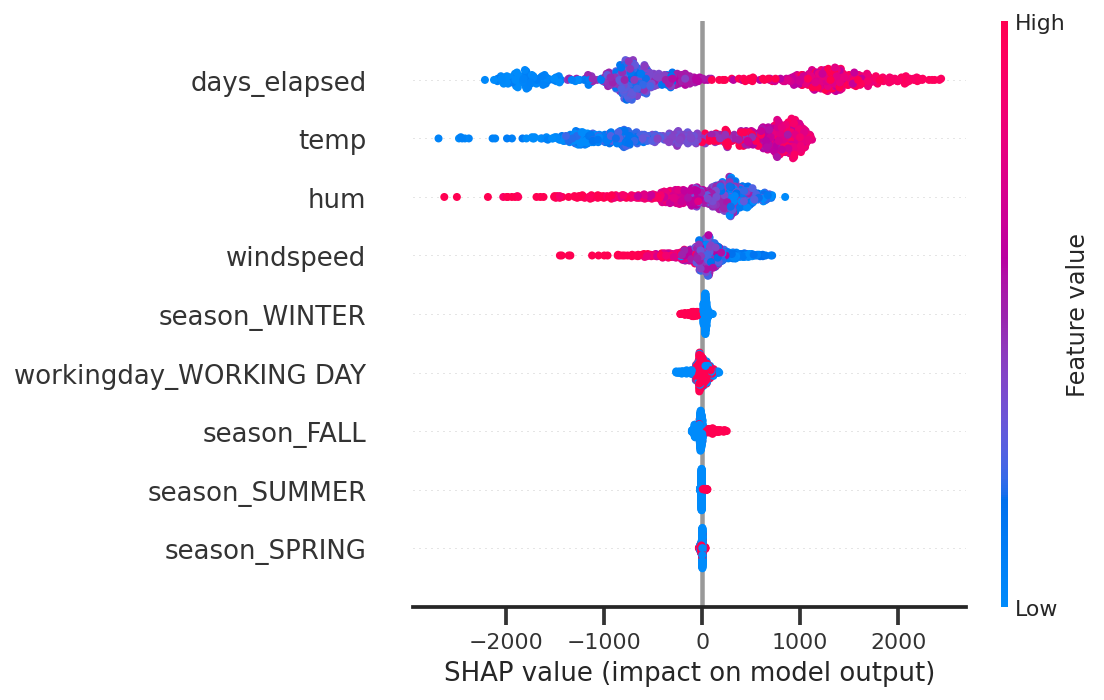

In [ ]:
shap.summary_plot(
    shap_values,
    regr_pipe['preprocessor'].transform(X)
)

### Individual Conditional Expectation (ICE)

Let us investigate the effect of **temperature** across the whole range, creating synthetic data from existing instances in the data, according to your ML model.

In [ ]:
X['temp'].min(), X['temp'].max()

(-5.2208712, 32.498349)

In [ ]:
temp_synth_data = np.linspace(X['temp'].min(), X['temp'].max(), 100)
temp_synth_data[:5], temp_synth_data[-5:]

(array([-5.2208712 , -4.83986898, -4.45886675, -4.07786453, -3.6968623 ]),
 array([30.9743401 , 31.35534233, 31.73634455, 32.11734678, 32.498349  ]))

Let us pick an random observation, from which we will produce synthetic ones by varying `temp` across its range.

In [ ]:
ex_instance = X.sample(1, random_state=42).drop(columns='temp')
ex_instance

,season,workingday,hum,windspeed,days_elapsed
703,FALL,WORKING DAY,73.375,11.666643,703


In [ ]:
temp_synth_df = pd.DataFrame(temp_synth_data, columns=['temp'])
temp_synth_df.head()

,temp
0,-5.220871
1,-4.839869
2,-4.458867
3,-4.077865
4,-3.696862


In [ ]:
synth_df = ex_instance.merge(temp_synth_df, how='cross')
print(synth_df.shape)
synth_df

(100, 6)


,season,workingday,hum,windspeed,days_elapsed,temp
0,FALL,WORKING DAY,73.375,11.666643,703,-5.220871
1,FALL,WORKING DAY,73.375,11.666643,703,-4.839869
2,FALL,WORKING DAY,73.375,11.666643,703,-4.458867
3,FALL,WORKING DAY,73.375,11.666643,703,-4.077865
4,FALL,WORKING DAY,73.375,11.666643,703,-3.696862
...,...,...,...,...,...,...
95,FALL,WORKING DAY,73.375,11.666643,703,30.974340
96,FALL,WORKING DAY,73.375,11.666643,703,31.355342
97,FALL,WORKING DAY,73.375,11.666643,703,31.736345
98,FALL,WORKING DAY,73.375,11.666643,703,32.117347


In [ ]:
pred = regr_pipe.predict(synth_df)
pred[:5], pred[-5:]

(array([3240.33950514, 3240.33950514, 3240.33950514, 3240.33950514,
        3240.33950514]),
 array([6928.18858531, 6928.18858531, 6928.18858531, 6928.18858531,
        6928.18858531]))

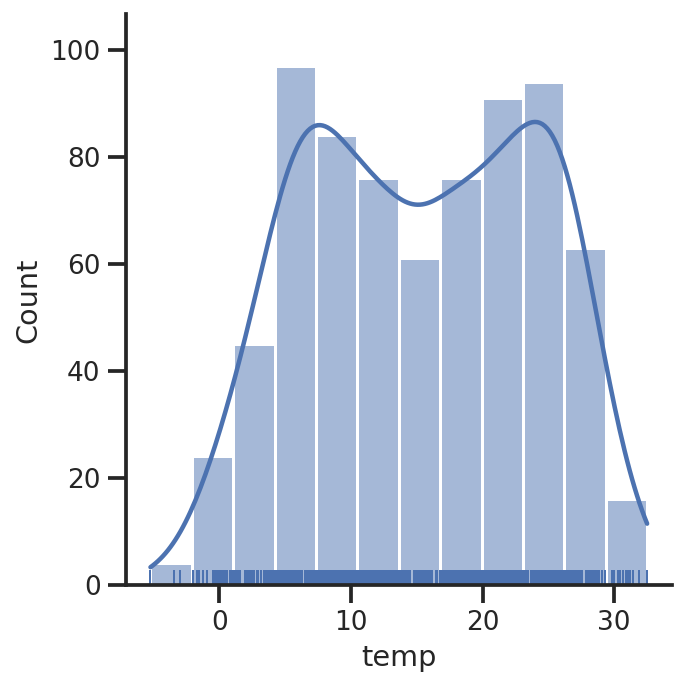

In [ ]:
sns.displot(X['temp'], kde=True, rug=True);

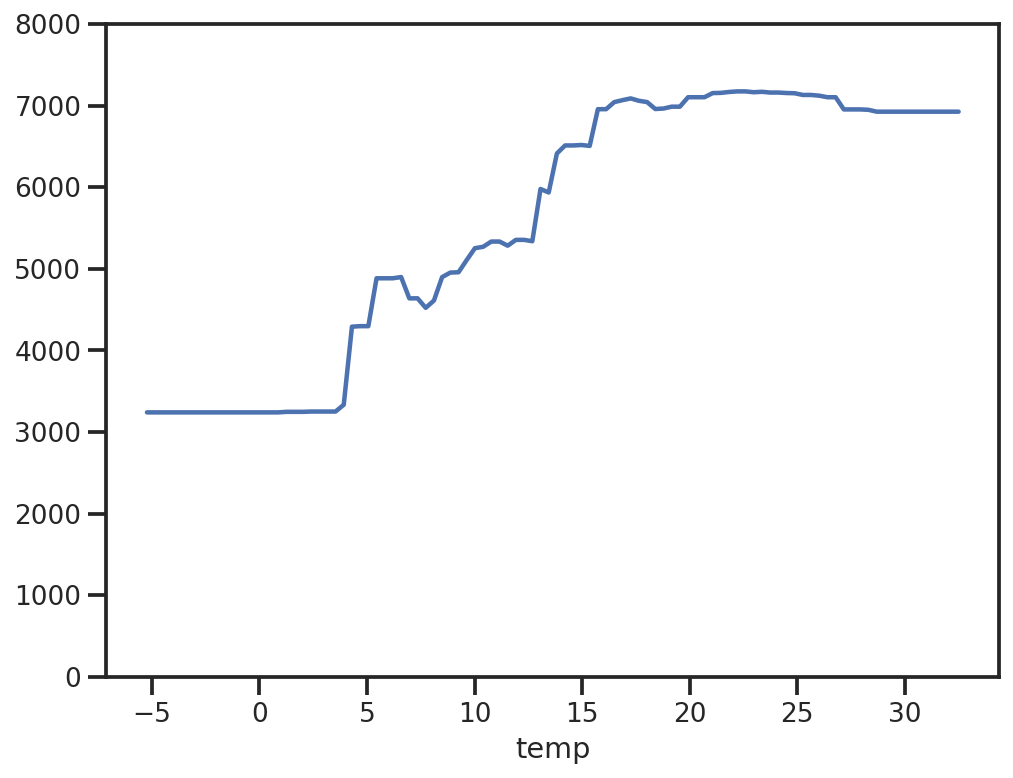

In [ ]:
ax = sns.lineplot(x=synth_df['temp'], y=pred);
ax.set_ylim(0, 8000);

### Partial Dependency Plot (PDP)

* Put simply, for a feature of interest (e.g., `temp`), a PDP represents the **average of all ICEs**.

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

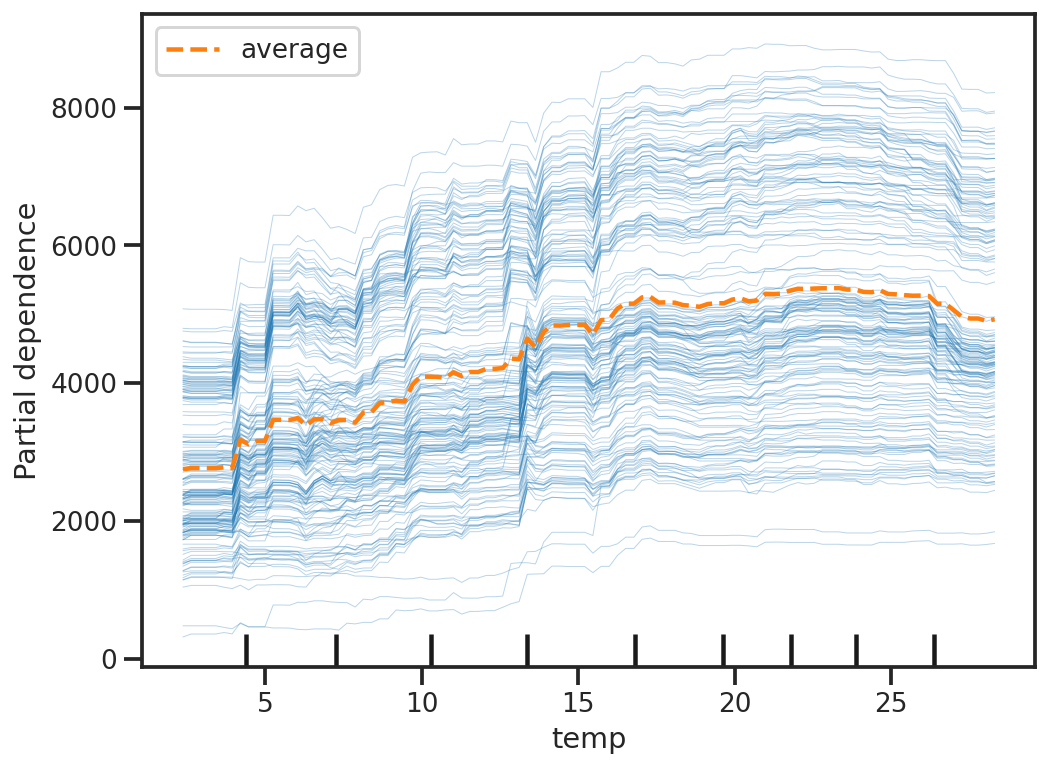

In [ ]:
PartialDependenceDisplay.from_estimator(
    regr_pipe, X_test, features=['temp'], kind='both'
);

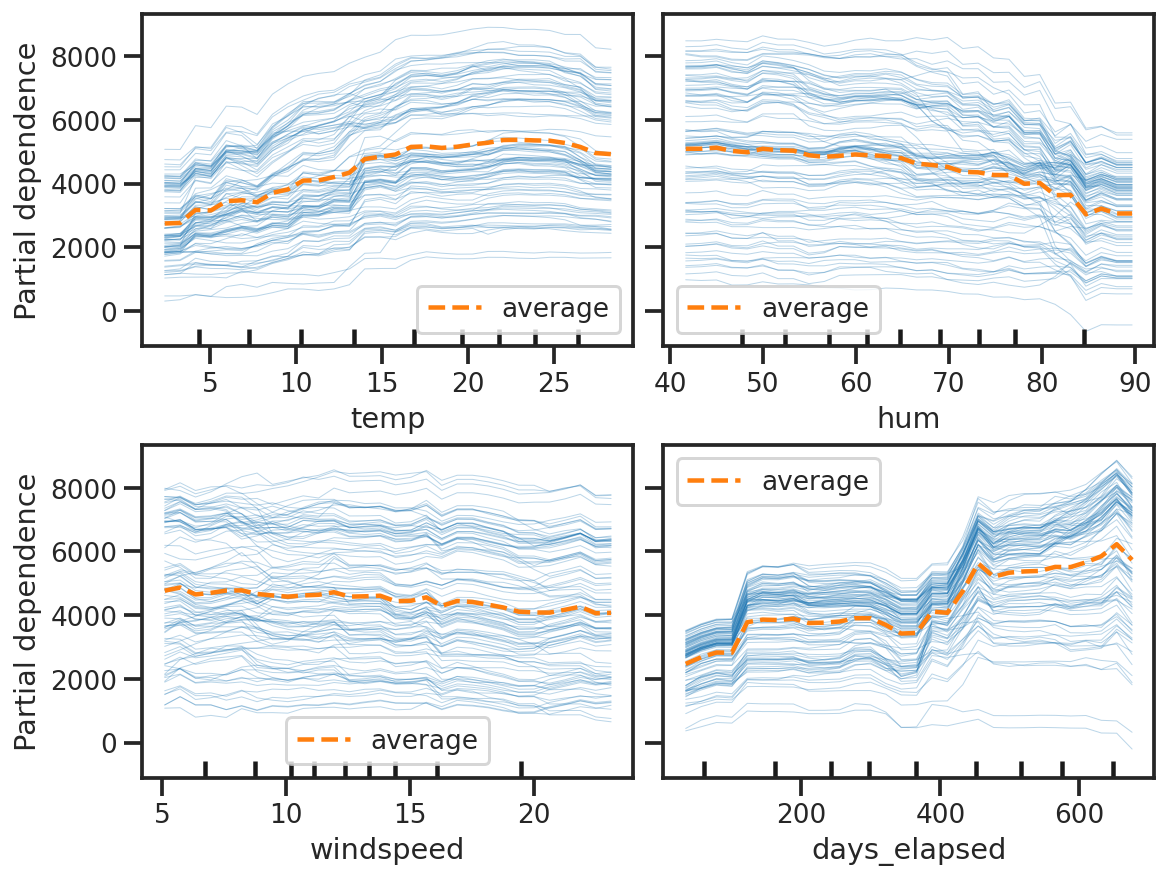

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    regr_pipe, X_test, features=X_test.select_dtypes(exclude='object').columns,
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

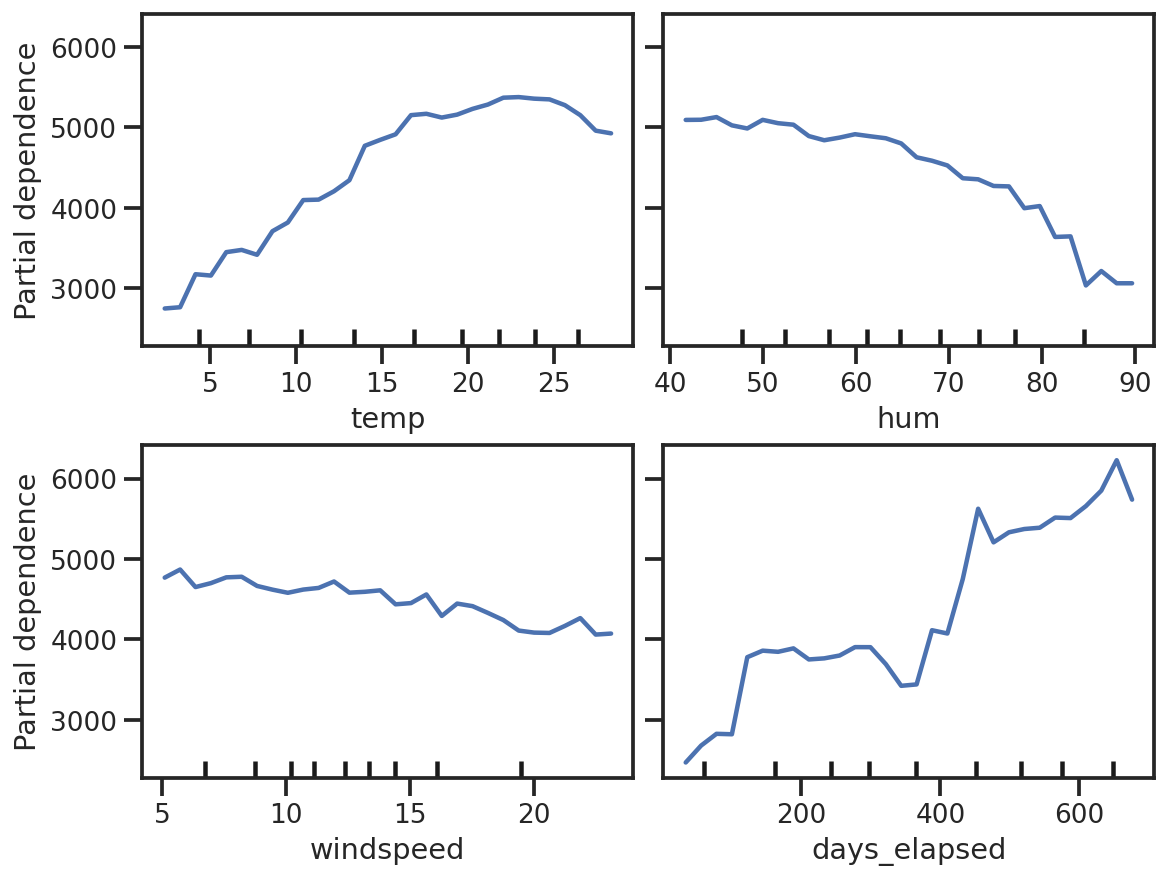

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    regr_pipe, X_test, features=X_test.select_dtypes(exclude='object').columns,
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

A 2D one gives us the possibility of analysis feature interactions (just the PDP curve; not feasible to show ICEs as well).

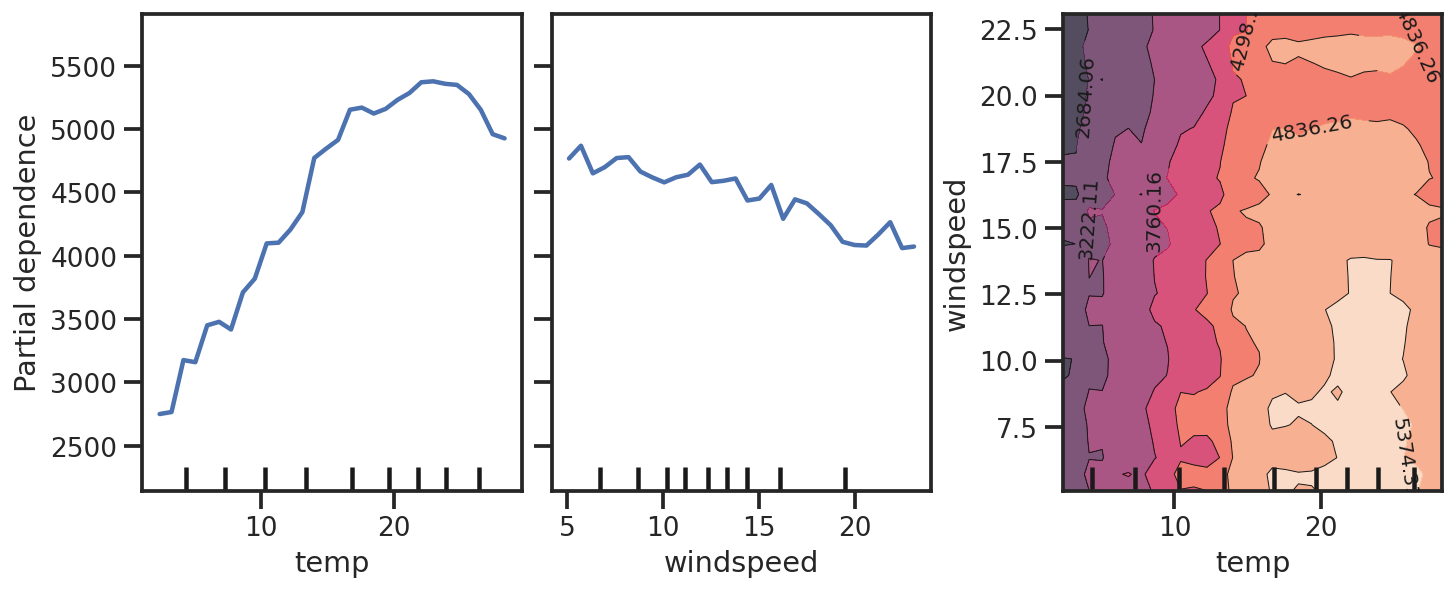

In [ ]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    regr_pipe, X_test,
    features=["temp", "windspeed", ("temp", "windspeed")],
    kind='average',
    ax=ax, n_cols=3,
    subsample=50, grid_resolution=30, n_jobs=2, random_state=0,
);

In [ ]:

# I was curious as to how many CPU cores I might have
# !lscpu

## Further Resources

* https://christophm.github.io/interpretable-ml-book/ice.html#ice

* https://christophm.github.io/interpretable-ml-book/pdp.html

* https://scikit-learn.org/stable/modules/partial_dependence.html

* contour plots:
    - https://youtu.be/acdX4YamDtU?t=230
    - https://en.wikipedia.org/wiki/Contour_line

    

## Lab Activities

* Try the PDP/ICE plots on a subset of the AMES dataset (for regression) and on the PIMA Diabetes dataset (for classification). You can look at the behaviour of a RandomForest, Gradient Boosted Tree, or even a linear model (regressor and classifier). You might want to use SHAP alongside to validate/cross-reference findings/insights.